<a href="https://colab.research.google.com/github/sebabecerra/ComputerVision/blob/main/Tarea4_SebastianBecerra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introducción a la Visión Computacional
## Tarea 4

#CORRER TODO EN GOOGLE COLAB
-----------------------
<div align="right">
Fecha de Entrega: Martes 24, Mayo 2022.
</div>

# 1. Proponer mejoras al sistema diseñado e implementado originalmete.
### Deteccion de Rostros usando un modelo pre-entrenado.

La principal innovacion y mejora propuesta en esta version de la tarea es detectar rostros con otro algoritmo y en tiempo real, utilizando accesos a la WebCam.

La base de este proyecto es la [Tarea 2](https://colab.research.google.com/drive/1ufd31_EmEJ0zMeV_pm1XfkOa3HArOnK4)

Sin embargo mas que una mejora es una continuacion del proyecto donde ahora la extesion es ocupar la WebCam para detectar rostros usando otro algoritmo. Este paso es fundametal para lograr el desarrolo final de la App D-Art que podria detectrar en tiempo real los rostros presentas en las obras de arte.

-----------------------

#2. Volver a investigar y averiguar si hay algún algoritmo entrenado o bien si se puede extender el algoritmo utilizado trabajado en la Tarea 2. 

En esta tarea, el el codigo se modifica de dos formas principalmente. 

  1.   Asi, con este codigo podremos acceder e interactuar con la WebCam para  obtener imágenes en tiempo real. 

  2. Ademas de lograr acceder a la WebCam la nueva propuesta permite detectar los rostros a las imagenes capturadas por la WebCam. Para este propósito, utilizaremos _**Haar Cascade de OpenCV**_ para realizar la detección de rostros en la imagen de nuestra cámara web.

  3. La ultima propuesta es lograr detecar los rostros en tiempo real al activar la WebCam para capturar video. 

A continuacion se detalla el algoritmo ultilizado en este proyecto.

-----------------------



## Detección de rostros o caras de Haar-cascade en OpenCV

Segun la docuemntacion, OpenCV viene con un entrenador y un detector. Si se requiere entrenar un propio clasificador para cualquier objeto como autos, aviones, etc, se podria utilizar este en OpenCV.

Aquí ocuparemos la deteccion sugerida por OpenCV que ya contiene muchos clasificadores pre-entrenados para cara, ojos, sonrisa, etc. Esos archivos son XML y se almacenan en opencv/data/haarcascades/. Con esto crearemos el detecor de rostros en base a OpenCV.

Primero necesitamos cargar los clasificadores XML requeridos. A continuación, cargue nuestra imagen de entrada (o vídeo) en modo escala de grises.



## Librerias requeridas y funciones auxiliares
A continuación para el desarrollo y mejora de la tarea 2 se necesitan implementar funciones para realizar la conversión entre diferentes tipos y formatos de datos de imagen.

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
##
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [ ]:
# Inicializar el modelo Haar Cascade para la deteccion de rostros
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
eye_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_eye.xml'))

In [ ]:
# Funcion para convertir el objeto Javascript en una imagen de OpenCV
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# funcion para convertir OpenCV Rectangle bounding box image en 
# base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convertir array en PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox en png para return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## Imagenes obtenidas con la WebCam

Para utilizar imagenes tomadas desde la WebCam el fragmento de código para **Captura de cámara** para utilizar la cámara web de su computadora.

Iniciando la web-cam

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capturando';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # datos de la imagen
  data = eval_js('takePhoto({})'.format(quality))
  # dar formato OpenCV a la imagen
  img = js_to_image(data) 
  # imagen en escala de grises
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # obtener las cordenadas para la caha y rostro usando Haar Cascade
  ##faces = face_cascade.detectMultiScale(gray)
  ##eyes  = eye_cascade.detectMultiScale(gray)
  # draw face bounding box on image

  faces = face_cascade.detectMultiScale(gray, 1.35, 1)
  for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(200,100,100),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
      cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(40,55,200),2)

  cv2.imwrite(filename, img)

  return filename

Ahora encontramos las caras en la imagen. Si se encuentran caras, devuelve las posiciones de las caras detectadas como Rect (x, y, w, h). Una vez que obtenemos estas ubicaciones, podemos crear un ROI para la cara y aplicar la detección de ojos en este ROI (ya que los ojos están siempre en la cara).

Correr para 'Capturar' y hacer una foto con la webcam.

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


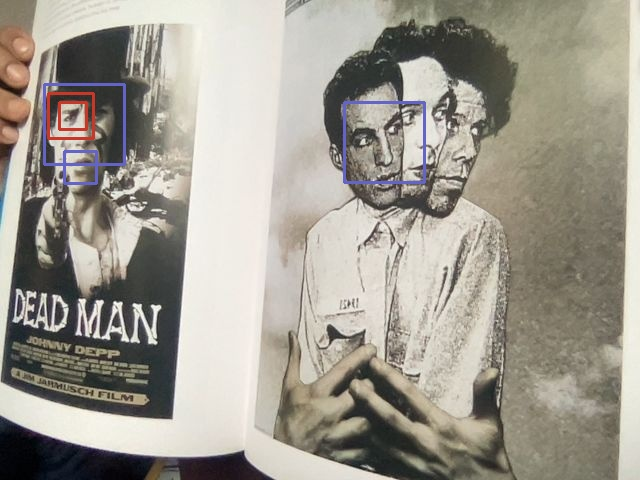

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


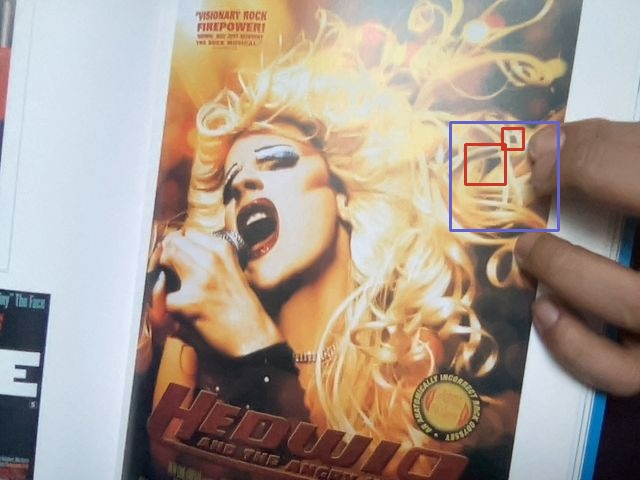

In [ ]:
try:
  filename = take_photo('photo1.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


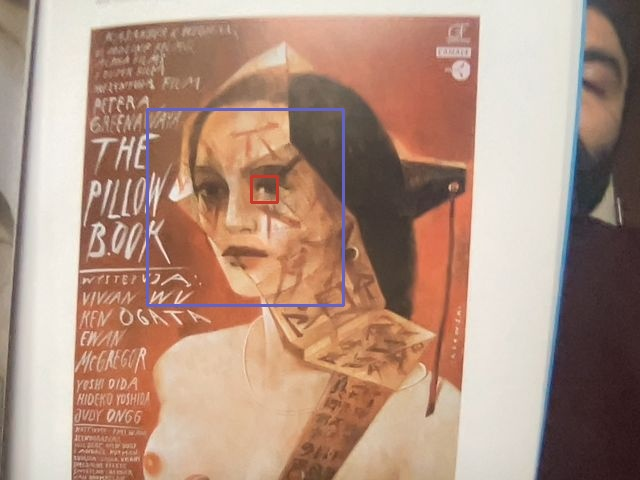

In [ ]:
try:
  filename = take_photo('photo2.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo7.jpg


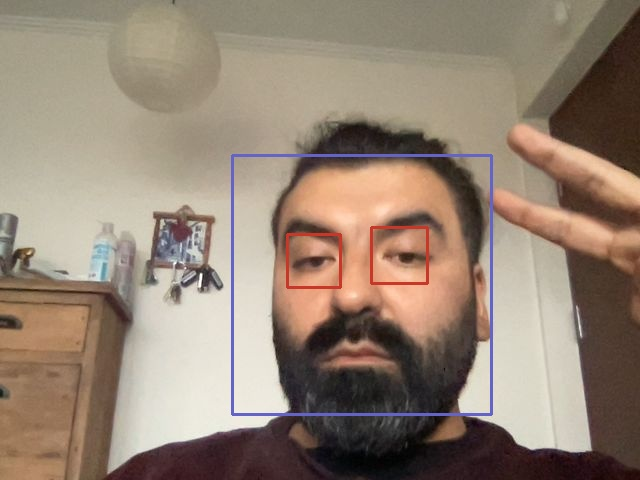

In [ ]:
try:
  filename = take_photo('photo3.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo1.jpg


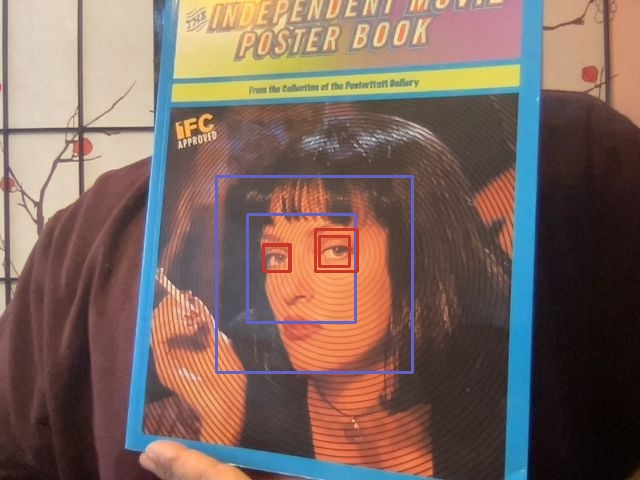

In [ ]:
try:
  filename = take_photo('photo4.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo2.jpg


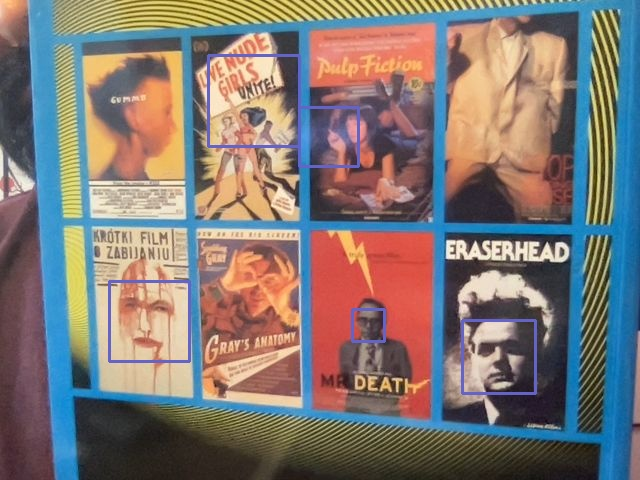

In [ ]:
try:
  filename = take_photo('photo5.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo3.jpg


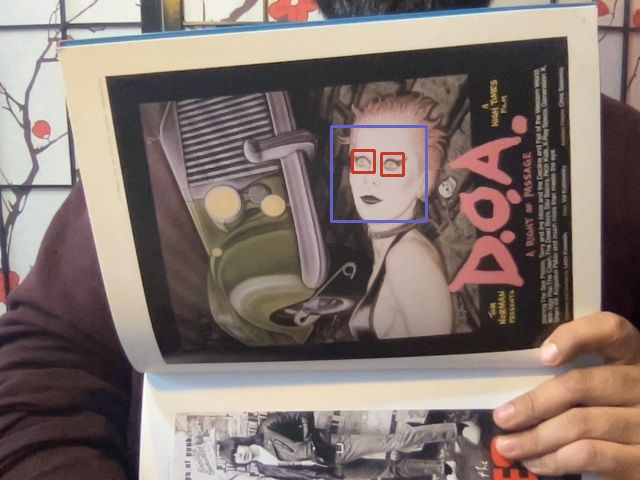

In [ ]:
try:
  filename = take_photo('photo6.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo4.jpg


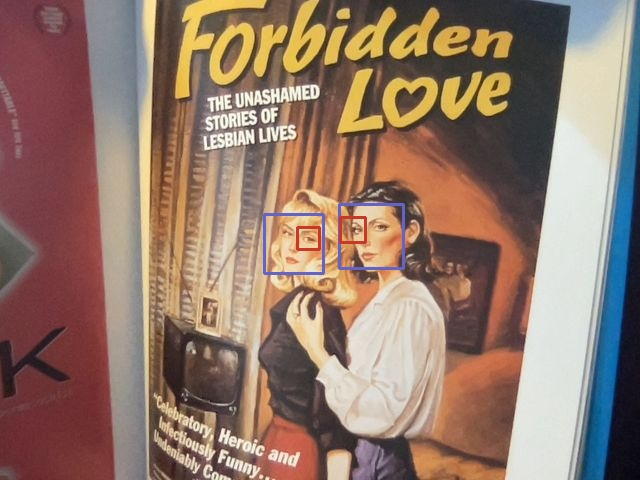

In [ ]:
try:
  filename = take_photo('photo7.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo4.jpg


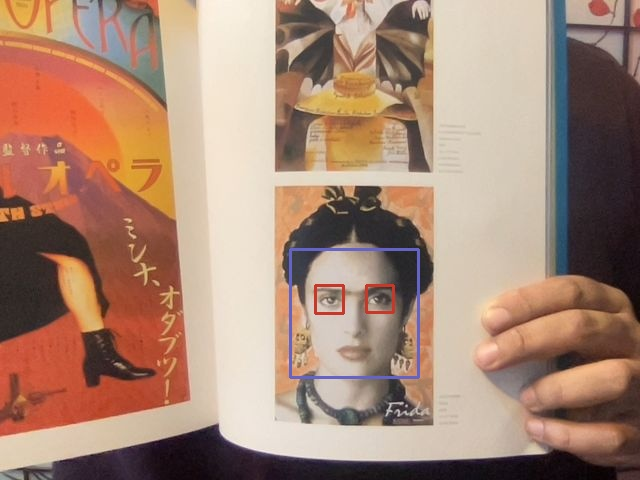

In [ ]:
try:
  filename = take_photo('photo8.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo5.jpg


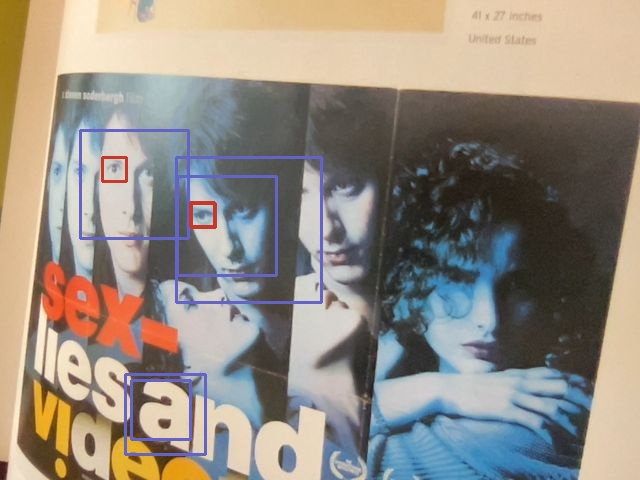

In [ ]:
try:
  filename = take_photo('photo9.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo6.jpg


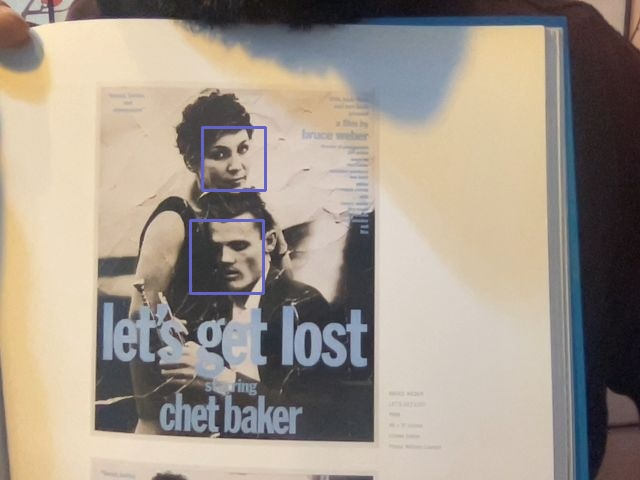

In [ ]:
try:
  filename = take_photo('photo10.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo7.jpg


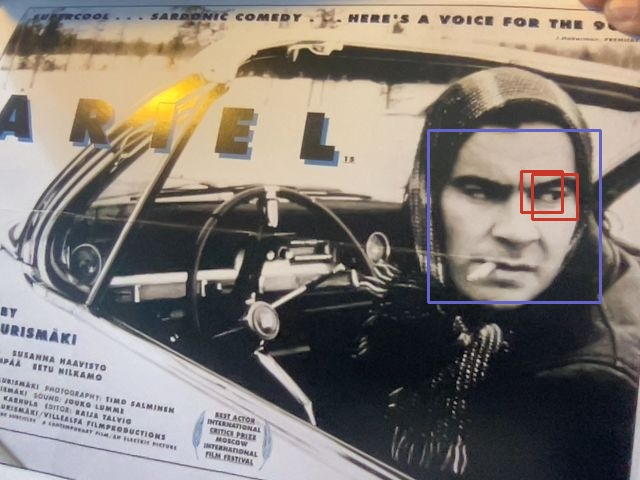

In [ ]:
try:
  filename = take_photo('photo11.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo8.jpg


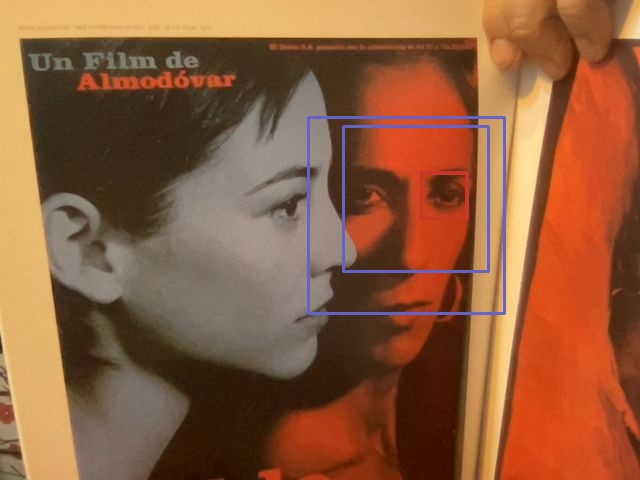

In [ ]:
try:
  filename = take_photo('photo12.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo9.jpg


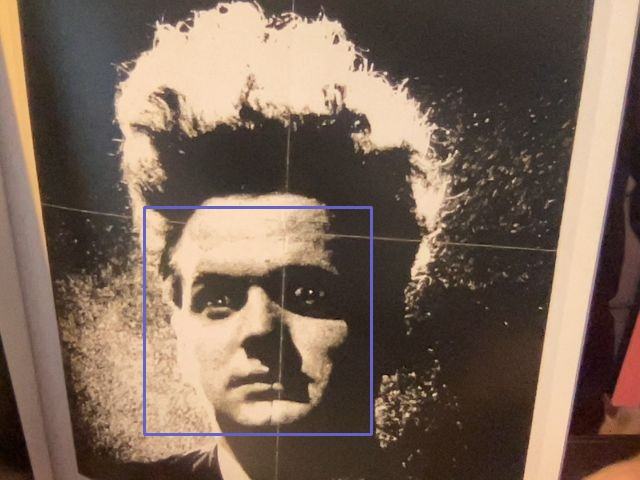

In [ ]:
try:
  filename = take_photo('photo13.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo10.jpg


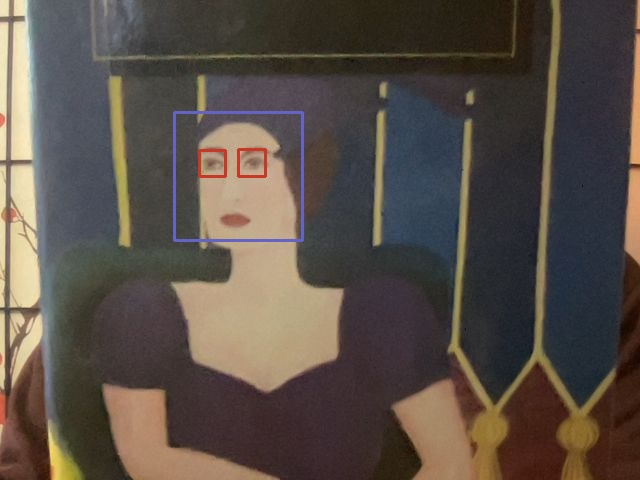

In [ ]:
try:
  filename = take_photo('photo14.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Comparado con la tarea 2, donde el algoritmo utilizado es MultiTask Cascaded Convolutional Neural (MCCN), el algoritmo de _**Haar Cascade de OpenCV**_ parece tener un desempeno inferior. Es este ejercio se observa que _**Haar Cascade**_ parece tener problemas al detectar rostros que no se encuentran justo de frente a la camara o donde la foto captada con la WebCam presenta problemas de nitidez. 
En la siguiente seccion se prueba otro algoritmo y se realiza la comparacion para cuatro fotografias.

#Probando Otro Algoritmo

El detector de rostros de utilizando deep learning de de OpenCV se basa en el marco del detector de disparo único (SSD) con una red base ResNet. La red se define y entrena utilizando el marco Caffe Deep Learning

Para realizar la deteccion se descarga el modelo de detección de rostros previamente entrenado, que consta de dos archivos:

1.   La definición de red (deploy.prototxt)
2.   Los pesos aprendidos (res10_300x300_ssd_iter_140000.caffemodel)

In [ ]:
# Cargamos la definicion de la red y los pesos 
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

In [ ]:
def take_photo2(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Reajusta el output para ajustar el elemento del video.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // espara para capturar el video con un click .
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
image_file4 = take_photo2()

In [ ]:
image = cv2.imread(image_file4)
# reajusta el tamano maximo
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]

In [ ]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)
# ajustamos el tamano 
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
# blob a través de la red neuronal para obtener las detecciones y predicciones.
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

# detecta y dibuja las boxes alrededor de las caras detectadas segun "confianza"
for i in range(0, detections.shape[2]):

	# extrae probabilidad asociada con la prediccion
	confidence = detections[0, 0, i, 2]

# filtrar las detecciones débiles asegurándose de que la `confianza` sea
# mayor que el umbral mínimo de confianza
	if confidence > 0.5:
		# calcula las coordenadas (x, y) del bounding box para el objeto
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# dibujar las bounding box de la cara junto con la probabilidad asociada
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

[INFO] loading model...
[INFO] computing object detections...


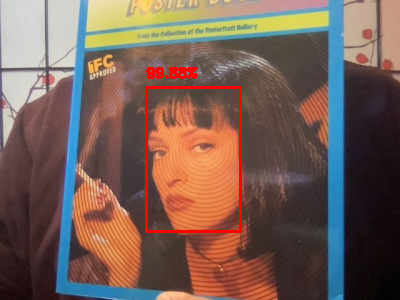

In [ ]:
cv2_imshow(image)

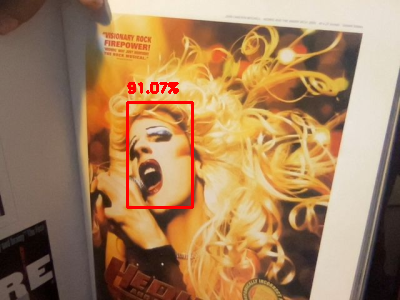

In [ ]:
cv2_imshow(image)

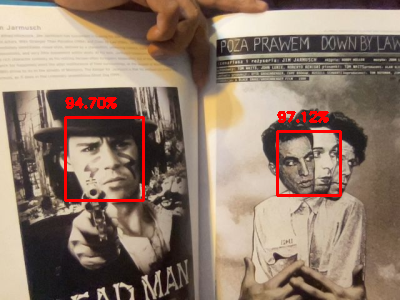

In [ ]:
cv2_imshow(image)

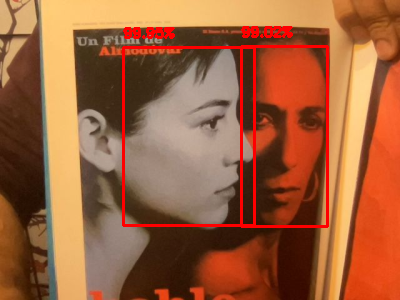

In [ ]:
cv2_imshow(image)

Como se puede apreciar al comparar el desempeno del nuevo algoritmo entrenado con el desarrollado en la seccion anterior podemos observar que el desempeno es superior. Principalmente para las fotografias donde _**Haar Cascade de OpenCV**_ tuvo problemas el nuevo algoritmo logra detectar los rostros sin mayor problema. 



## Detectar imagenes en tiempo real (Video WebCam)

### ATENCION: ESTA PARTE DEBE SER EJECUTADA PARA VER COMO FUNCIONA

Esta parte de la tarea es una total innovacion respecto la tarea 2. Propongo un sistma para detectar los rostros en tiempo real operando la WebCam desde colab.

Obtener la deteccion en tiempo real de rostros  traves de la WebCam es mas complejo y debemos anadir bloques adicionales de codigo. 

Para esto, necesitamos iniciar una transmisión de video usando nuestra WebCam como entrada. Luego ejecutamos cada cuadro a través de nuestro programa (detección de rostros) y creamos una imagen superpuesta que contiene un cuadro delimitador de detección. Luego, superponemos la imagen del cuadro delimitador nuevamente en el siguiente cuadro de nuestra transmisión de video.

![image.png]</center>

#D-ART: Deteccion de obras de Arte.
-----------------------
![picture](https://drive.google.com/uc?export=view&id=1j3Jfw24mNMzwh6mUPJgnwVQKS0Ql8sNp)


In [ ]:
# JavaScript para crear un video en stream usand la webcam as como entrada
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Estado:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Cuando este listo, click aqui o en el video para detener el stream</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

#Correr "EN GOOGLE COLAB" este celda para activar el video en streaming y detectar rostros.

In [ ]:
# Emepezar el video en streaming con video dese la WebCam
video_stream()
# etiquetar el video
label_html = 'Capturando...'
# bounding box en blanco
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # transformar JS response a imagen de OpenCV
    img = js_to_image(js_reply["img"])

    # bounding box transparente
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # imagen en escala de grises para deteccion de rostros. 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # obtener las coordeadas para la region de deteccion de rostros
    faces = face_cascade.detectMultiScale(gray)
    # bounding box para rostro sobrescrita
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convertir bbox en bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # actualizar bbox para el movimiento de los marcos de deteccion
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

# 3. Escribir un informe o entregar el notebook con comentarios y documentación, incluyendo el análisis (comentando) de la comparación con los resultados de la Tarea 2. Notar que pudiera ser que el resultado es inferior al de la Tarea 2, lo importante es el comentario o discusión del por qué se mejoró o empeoraron los nuevos resultados.

Rta: En esta entrega se presentan dos algoritmos distintos y se evalua el desempeno interactuando con la WebCAm integrada en el compudor para hacer una deteccion en tiempo real. 

Todas las funciones, codigo y detalles se encuentran en este notebook.